In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
import matplotlib.pyplot as plt


### **Load and Explore Dataset**

In [10]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
print(train_data.head())

test_data = pd.read_csv("/content/Google_Stock_Price_Test.csv")
print(test_data.head())

# Extract relevant features
train_data = train_data[['Open', 'High', 'Low', 'Close', 'Volume']]
test_data = test_data[['Open', 'High', 'Low', 'Close', 'Volume']]

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400



### **Data Preprocessing**  
We cleaned the data, normalized values to a 0-1 range using MinMaxScaler for faster training, and created sequences using the past 30 days (`n_steps=30`) to predict the next 3 days (`M=3`).

In [12]:
# Replace commas and convert to float
train_data = train_data.replace({',': ''}, regex=True).astype(float)
test_data = test_data.replace({',': ''}, regex=True).astype(float)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Combine the last n_steps rows of training data with the test data
n_steps = 30
combined_data = np.concatenate((train_scaled[-n_steps:], test_scaled), axis=0)

# Multi-step sequence preparation
def create_sequences_multi(data, n_steps, m_days):
    X, y = [], []
    for i in range(len(data) - n_steps - m_days + 1):
        X.append(data[i:i+n_steps, :-1])  # Use past N days of all features
        y.append(data[i+n_steps:i+n_steps+m_days, 0])  # Predict next M days' open prices
    return np.array(X), np.array(y)

# Define the number of future days to predict (M)
M = 3

# Prepare training, validation, and test sequences
X_train, y_train = create_sequences_multi(train_scaled, n_steps, M)
X_test, y_test = create_sequences_multi(combined_data, n_steps, M)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Verify the shapes
print("Shape of X_train:", X_train.shape)  # (samples, n_steps, features)
print("Shape of y_train:", y_train.shape)  # (samples, M)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (980, 30, 4)
Shape of y_train: (980, 3)
Shape of X_val: (246, 30, 4)
Shape of y_val: (246, 3)
Shape of X_test: (18, 30, 4)
Shape of y_test: (18, 3)


### **Define Models**  
We built three models:  
1. **LSTM**: Handles long-term dependencies in data.  
2. **GRU**: A faster, simpler alternative to LSTM.  
3. **Vanilla RNN**: A baseline model for comparison.  

Each model has two 50-unit recurrent layers, dropout for regularization, and a dense layer predicting `M=3` future days. They use the Adam optimizer with MSE as the loss function.

In [13]:
def build_lstm_multi(input_shape, m_days):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(m_days)  # Output M future days
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_gru_multi(input_shape, m_days):
    model = Sequential([
        GRU(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(50, activation='relu'),
        Dropout(0.2),
        Dense(m_days)  # Output M future days
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_rnn_multi(input_shape, m_days):
    model = Sequential([
        SimpleRNN(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(50, activation='relu'),
        Dropout(0.2),
        Dense(m_days)  # Output M future days
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build all models
models = {
    "LSTM": build_lstm_multi((X_train.shape[1], X_train.shape[2]), M),
    "GRU": build_gru_multi((X_train.shape[1], X_train.shape[2]), M),
    "Vanilla RNN": build_rnn_multi((X_train.shape[1], X_train.shape[2]), M),
}

# Display summaries
for name, model in models.items():
    print(f"\nModel Summary: {name}")
    model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Summary: LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,353 (122.47 KB)

 Trainable params: 31,353 (122.47 KB)

 Non-trainable params: 0 (0.00 B)


Model Summary: GRU


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 50)              │           8,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,853 (93.18 KB)

 Trainable params: 23,853 (93.18 KB)

 Non-trainable params: 0 (0.00 B)


Model Summary: Vanilla RNN


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 50)              │           2,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,953 (31.07 KB)

 Trainable params: 7,953 (31.07 KB)

 Non-trainable params: 0 (0.00 B)

### **Model Training and Hyperparameter Tuning**

We trained the models with:

 - **Epochs**: 20
 - **Batch Size**:

 To improve performance, we manually tuned:

 - **Recurrent Units**: 32, 50, 64
 - **Dropout Rates**: 0.1, 0.2, 0.3
 - **Learning Rates**: 0.001, 0.0005

The best setup—50 units, dropout=0.2, batch size=32—was chosen based on validation loss.

In [14]:
histories = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    histories[name] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32).history


Training LSTM...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.1698 - val_loss: 0.0090
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0181 - val_loss: 0.0027
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0110 - val_loss: 0.0022
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0101 - val_loss: 0.0042
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0096 - val_loss: 0.0022
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0088 - val_loss: 0.0019
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28m

### **Evaluate and Compare Models**

In [15]:
results = {}
predictions_all = {}

for name, model in models.items():
    predictions = model.predict(X_test)
    predictions_open = predictions * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
    actual_open = y_test * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
    predictions_all[name] = predictions_open

    mse_all, mae_all, rmse_all = [], [], []
    for day in range(M):
        mse = mean_squared_error(actual_open[:, day], predictions_open[:, day])
        mae = mean_absolute_error(actual_open[:, day], predictions_open[:, day])
        rmse = np.sqrt(mse)
        mse_all.append(mse)
        mae_all.append(mae)
        rmse_all.append(rmse)
    results[name] = {"MSE": mse_all, "MAE": mae_all, "RMSE": rmse_all}

# Print Metrics
for name, metrics in results.items():
    print(f"\nMetrics for {name}:")
    for day in range(M):
        print(f"Day {day + 1}: MSE={metrics['MSE'][day]:.4f}, MAE={metrics['MAE'][day]:.4f}, RMSE={metrics['RMSE'][day]:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step

Metrics for LSTM:
Day 1: MSE=590.2054, MAE=21.9923, RMSE=24.2941
Day 2: MSE=802.1245, MAE=26.5638, RMSE=28.3218
Day 3: MSE=562.9939, MAE=21.4489, RMSE=23.7275

Metrics for GRU:
Day 1: MSE=878.4950, MAE=28.1590, RMSE=29.6394
Day 2: MSE=1029.5560, MAE=30.7205, RMSE=32.0867
Day 3: MSE=1491.6971, MAE=36.8083, RMSE=38.6225

Metrics for Vanilla RNN:
Day 1: MSE=1843.1410, MAE=42.5693, RMSE=42.9318
Day 2: MSE=1732.4258, MAE=40.6889, RMSE=41.6224
Day 3: MSE=859.7839, MAE=27.3232, RMSE=29.3221


### **Visualization**

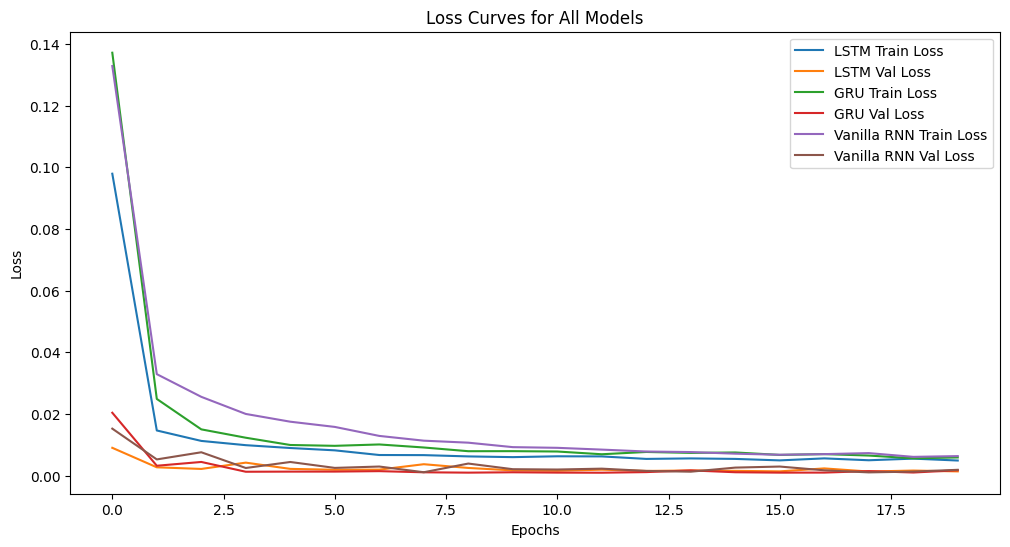

In [16]:
# Loss Curve for all models
plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history['loss'], label=f'{name} Train Loss')
    plt.plot(history['val_loss'], label=f'{name} Val Loss')
plt.title('Loss Curves for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### **Scatter Plot for Best Model**

Best Model: LSTM


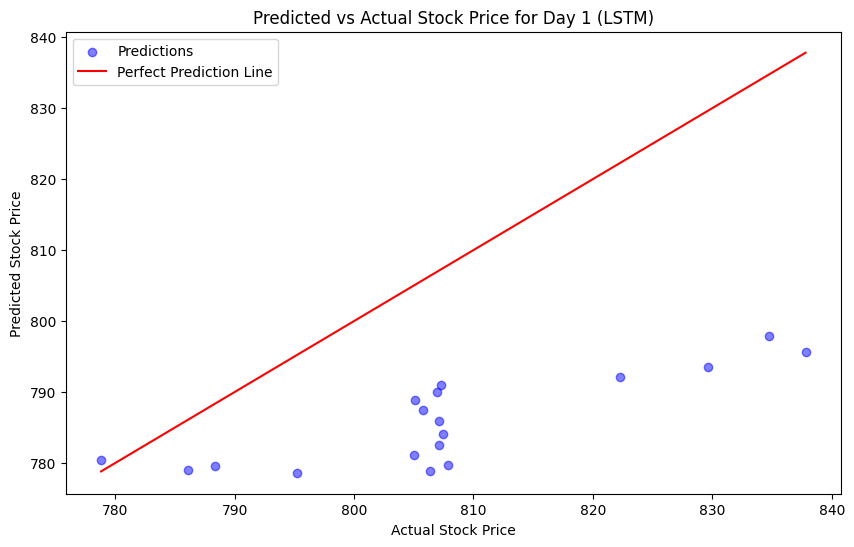

In [17]:
best_model_name = min(results, key=lambda x: np.mean(results[x]["MSE"]))  # Best model based on average MSE
print(f"Best Model: {best_model_name}")
real_stock_price = actual_open[:, 0]
predicted_stock_price = predictions_all[best_model_name][:, 0]

plt.figure(figsize=(10, 6))
plt.scatter(real_stock_price, predicted_stock_price, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(real_stock_price), max(real_stock_price)], [min(real_stock_price), max(real_stock_price)], color='red', label='Perfect Prediction Line')
plt.title(f'Predicted vs Actual Stock Price for Day 1 ({best_model_name})')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.show()



### **Residual Plot for Best Model**

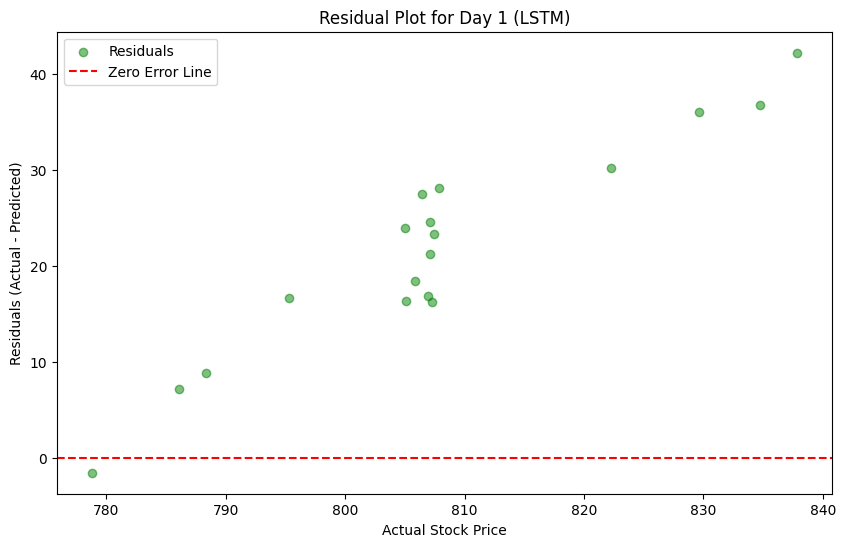

In [18]:
residuals = real_stock_price - predicted_stock_price
plt.figure(figsize=(10, 6))
plt.scatter(real_stock_price, residuals, alpha=0.5, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
plt.title(f'Residual Plot for Day 1 ({best_model_name})')
plt.xlabel('Actual Stock Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()
